In [1]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2
from contextlib import suppress
import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa
from cycler import cycler
import scipy
import seaborn as sns
import sys
import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
from scipy.signal import savgol_filter
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from matplotlib import style



#own libary
import nsidc 

from functions_pmrs import loadCM
from functions_pmrs import loadCMSAV
from functions_pmrs import applyshift
from functions_pmrs import calculateQR
from functions_pmrs import probability
from functions_pmrs import NQT
from functions_pmrs import calc_performance_scores_new


In [2]:
#SELECT BOUNDS AND START / END DATES
bounds = [( -19., 20.),
          (-11., 27.),
         ]

# start_date = datetim.datetime(2002, 5, 29) # Start of the AMSR-E period
# start_date = datetime.datetime(2004, 1, 1) # date after data recovery
# end_date = datetime.datetime(2009, 12, 31)  # only a few days to make a demonstration
# end_date = datetime.datetime(2004, 6, 30)  # use this end date to cover the whole AMSR-E period.
# end_date = datetime.datetime(2002, 1, 2)

#---------------------------#---------------------------#---------------------------#---------------------------#

#Select set of POI's to use

# points = pd.read_csv('poizambeziplain.csv')   #Kalabo (weinig goede resultaten)
points = pd.read_csv('poi_senaga.csv')
# points = pd.read_csv('POIs_RE_3p.csv')


#adjust according to number of points in POI's
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1])]
#                    (points.xcoord[2],points.ycoord[2]),
#                    (points.xcoord[3],points.ycoord[3]),
#                    (points.xcoord[4],points.ycoord[4])]
#                    (points.xcoord[5],points.ycoord[5])]
#                    (points.xcoord[6],points.ycoord[6]) 


# Download discharge data, no adjustment 
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',parse_dates=['DATE'],index_col = ['DATE'],na_filter=True)
dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',na_filter=True) #,parse_dates=['DATE'],index_col = ['DATE']
dQ['Date'] = pd.to_datetime(dQ['Date'])



#---------------------------#---------------------------#---------------------------#---------------------------#

# DOWNLOAD THE CORRECT DATA
# This cell calls the right download and "glues" the years together. 

fns=None

year = 2009  #change year to select specific year to see [2002-2011]

# 25 km resolution AMSMR DATA one year
# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/*.nc') # select this line to get the whole AMSR-E period

# SAT  = 'AMSRE'
SAT = 'DSMP'


#select this next one for full period data string (whole DSMP period)
fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/DMSP/*.nc') # select this line to get the whole AMSR-E period

# 3.125 km resolution PMSR DATA

# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/*.nc') # select this line to get the whole AMSR-E period

fns.sort()
ds = xr.open_mfdataset(fns)

#---------------------------#---------------------------#---------------------------#---------------------------#

# Discharge data location
# location = 'Kalabo'  
location = 'Senanga'
# location = 'Lukulu'


#---------------------------#---------------------------#---------------------------#---------------------------#


# TRANSFORMING, NO ADJUSTMENT NEEDED
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)
points_x, points_y = zip(*points_xy)

#---------------------------#---------------------------#---------------------------#---------------------------#
sns.set()

<ipython-input-2-f3e00180d5f2>:66: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fns)
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/backends/api.py:926: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:77: Fut

In [3]:

shift= 14
rollingvalue = 1
selection= 6 # < number of months to be choosen
plot = 1
windowlength =21
polyorder =1


/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


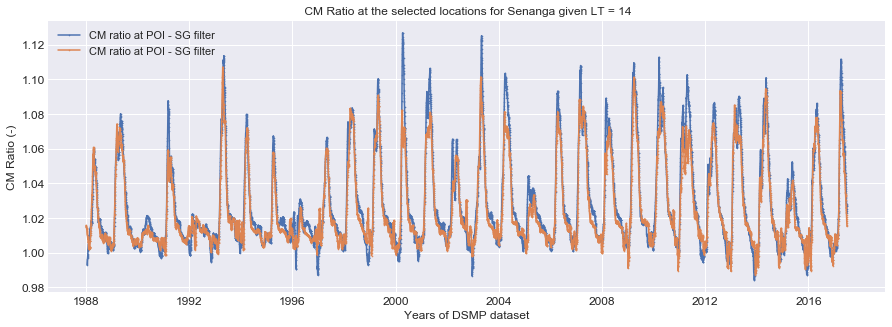

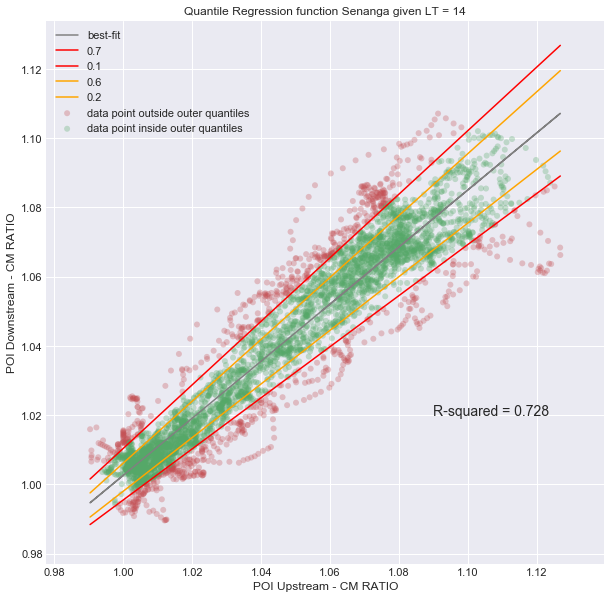

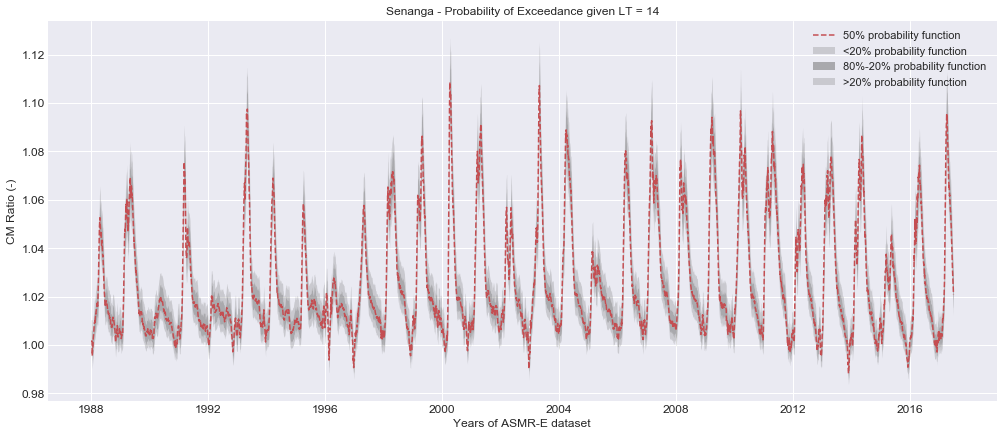

In [4]:
# df = loadCM(points_xy,ds, rollingvalue) 
df = loadCMSAV(points_xy, ds, windowlength, polyorder)
# df= df[df.index.year==2001]
plot=1
df = applyshift(df,rollingvalue,shift,plot,SAT)
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Final/Data_{shift}_{location}_{SAT}.png'),dpi=400)


# df= df[df.index.year<2010]
# df= df[df.index.year>2000]
plot=1
plot=1
df = df
fits,res = calculateQR(df,selection,plot,shift,location)
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Final/QR_{shift}_{location}_{SAT}.png'),dpi=400)
plot=1
pred = probability(df, fits, plot, shift,location)
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Final/Prop_{shift}_{location}_{SAT}.png'),dpi=400)

obs = df.POI4.values.copy()


In [5]:
trigger = df.quantile([0.6,0.7,0.9,0.95, 0.98, 0.99])
trigger






,POI1,POI4
0.60,1.022062,1.018426
0.70,1.032473,1.027621
0.90,1.073850,1.066417
0.95,1.084756,1.073952
0.98,1.097634,1.082789
0.99,1.103895,1.088801


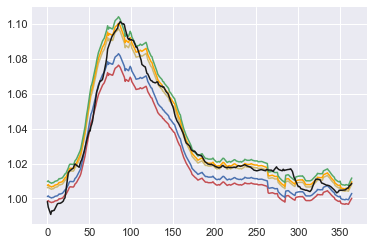

In [6]:
plot=0
shift=14
df = loadCMSAV(points_xy, ds, windowlength, polyorder)
df = applyshift(df,rollingvalue,shift,plot,SAT)
fits,res = calculateQR(df,selection,plot,shift,location)


df=df[df.index.year==2009]
pred = probability(df, fits, plot, shift,location)
obs = df.POI4.values.copy()


plt.plot(pred[0],'r')
plt.plot(pred[1],'b')
plt.plot(pred[5],'y')
plt.plot(pred[6],'orange')
plt.plot(pred[7],'g')
plt.plot(obs,'k')



In [7]:

# percentile=0
threshold = 1.05
dt=10


# df.max()
print(np.nanmax(pred[6]))
print(np.nanmax(obs))
len(pred)


1.1003773212432861
1.1012958


9

## Probability of Exceedance (CHECK!!!)

Percentile 0 is 90%th percentile with a probabilty of exceedance of 10%

Percentile 1 is 75%th percentile with a probabilty of exceedance of 25%

Percentile 2 is 50%th percentile with a probabilty of exceedance of 50%

Percentile 3 is 25%th percentile with a probabilty of exceedance of 75%

Percentile 4 is 10%th percentile with a probabilty of exceedance of 90%

In [52]:


def calc_performance_scores_new(df, obs, pred, threshold , dt, percentile):
#     np.seterr(divide='ignore', invalid='ignore')

    df = np.where((df.index.month == 2) & (df.index.day == 1))[0] # select only the moment in time the rainseason starts to find the first moment above the trheshold
    performance = np.zeros((len(df),4)) # create performance matrix 1 = date obs_threshold 2 obs_threshold 3. date pred_thres 4 pred_thres
   
    for t in range (30): # 30 for DSMP data set, 8 for AMSR-E, (4,5 for a year)
        obs_threshold = np.where((obs[df[t]: df[t]+365]) > threshold)[0] 


        if len(obs_threshold) > 0:   #alles wat groter dan nul is -> hit of een miss
                obs_threshold0 = obs_threshold[0] + df[t]
                pred_threshold = np.where(pred[percentile][obs_threshold0-dt:obs_threshold0+dt] > threshold)[0] + (obs_threshold0-dt)
                
                if len(pred_threshold) > 0: #hit
                    performance [t][0] = obs_threshold0 
                    performance [t][1] = 1
                    performance [t][2] = min(pred_threshold)       
                    performance [t][3] = 1      
#                     print('Hit')
                else:       # miss!            
                    performance [t][0] = obs_threshold0 
                    performance [t][1] = 1           
                    performance [t][2] = len(pred_threshold)
                    performance [t][3] = 0
#                     print('Miss')    
                    
           
        
        pred_threshold2 = np.where((pred[percentile][df[t]: df[t]+365]) > threshold)[0]

        if len(pred_threshold2)> 0: #alles wat groter dan nul is ->  FA of HIT
                
                pred_threshold3 = pred_threshold2[0]  + df[t]
                obs_threshold2 = np.where(obs[pred_threshold3-dt:pred_threshold3+dt] > threshold)[0]  
                
                if len(obs_threshold2) == 0: #alles wat groter dan nul is -> FA of CN
                    
                    performance [t][0] = len(obs_threshold2) 
                    performance [t][1] = 0
                    performance [t][2] = pred_threshold3
                    performance [t][3] = 1    
#                     print('False Alarm')   
       
        if len(obs_threshold) == 0: # CN
             if len(pred_threshold2) == 0:
                    
                    performance [t][0] = -999
                    performance [t][1] = 0           
                    performance [t][2] = -999
                    performance [t][3] = 0     
#                     print('Correct Negative')

    performance =pd.DataFrame(performance)
    
    performance.columns = ['day obs', 'obs', 'day pred', 'pred']    
    hits = len(np.where((performance.obs==1) & (performance.pred ==1))[0])    
    false_al = len(np.where((performance.obs==0) & (performance.pred ==1))[0])
    misses = len(np.where((performance.obs==1) & (performance.pred ==0))[0])
    corr_neg = len(np.where((performance.obs==0) & (performance.pred ==0))[0])
#     corr_neg = hits+misses



    try:
        output = np.zeros((4,))
        
        if hits+misses ==0:
            output[0]=np.nan
        else:
            output[0] = np.sum(hits) / (np.sum(hits) + np.sum(misses)) #Probability of Detection or  HR
       
        if hits+false_al ==0:
            output[1]=np.nan
        else:
            output[1] = np.sum(false_al) / (np.sum(hits) + np.sum(false_al)) #False Alarm Ratio
        
        if false_al+corr_neg ==0:
            output[2]=np.nan
        else:
            output[2] = np.sum(false_al) / (np.sum(false_al) + np.sum(corr_neg)) #Probability of fase detectiono or false alarm rate

        if hits+false_al+misses ==0:
            output[3]=np.nan
        else:
            output[3] = np.sum(hits) / (np.sum(hits) + np.sum(false_al) + np.sum(misses)) #Critical succes index
        

    except ZeroDivisionError:
        return -99
   

    metric = np.zeros((4,))
    metric[0] = hits
    metric[1] = false_al
    metric[2] = misses
    metric[3] = corr_neg

    
    return (performance,output,metric)
      
    

In [125]:
plot=0

df = loadCMSAV(points_xy,ds,windowlength, polyorder)
df = applyshift(df,rollingvalue,shift,plot,SAT)

ROC(POD,FAR,POFD,CSI) for is: [[1.         0.         0.         1.        ]
 [1.         0.         0.         1.        ]
 [       nan 1.         0.03333333 0.        ]
 [       nan 1.         0.03333333 0.        ]
 [       nan 1.         0.03333333 0.        ]
 [       nan 1.         0.03333333 0.        ]
 [       nan 1.         0.03333333 0.        ]
 [       nan 1.         0.03333333 0.        ]
 [       nan 1.         0.03333333 0.        ]]


,POD,FAR,POFD,CSI,Classification
10%,1.0,0.0,0.000000,1.0,YES
20%,1.0,0.0,0.000000,1.0,YES
30%,NaN,1.0,0.033333,0.0,NO
40%,NaN,1.0,0.033333,0.0,NO
50%,NaN,1.0,0.033333,0.0,NO
60%,NaN,1.0,0.033333,0.0,NO
70%,NaN,1.0,0.033333,0.0,NO
80%,NaN,1.0,0.033333,0.0,NO
90%,NaN,1.0,0.033333,0.0,NO


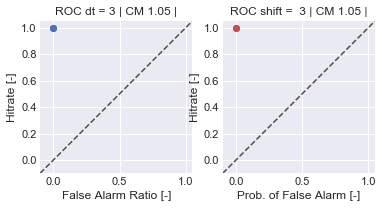

In [20]:

dt =3
shift=14
threshold=1.05
# percentile = 0

ROC =np.zeros((9,4))
plot=0

for percentile in range(9):
#     print(f'percentile:{percentile}')
    performance, output, metric = calc_performance_scores_new(df, obs, pred, threshold , dt, percentile)

#     print(f'percentile from df {percentile}')
#     print(output)
#     print(performance)
#     print(f'{performance}')
#     print(f'output: {output}')
#     print(f'METRIC: HIT,FA,MISS,CN: print metric for percentile {percentile}: {metric}')
    ROC [percentile] = output 


print(f'ROC(POD,FAR,POFD,CSI) for is: {ROC}')
result = pd.DataFrame(data=ROC,index=['10%','20%','30%','40%','50%','60%','70%','80%','90%'],columns=['POD','FAR','POFD','CSI']) #
result['Classification'] = np.where(((result.FAR<0.51) & (result.POD>0.51)),'YES','NO')

# auc = np.trapz(ROC[:,0],ROC[:,2])
plt.subplot(1,2,1)
plt.plot(ROC[:,2],ROC[:,0],'-o',color ='b')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'ROC dt = {dt} | CM {threshold} |')
plt.ylabel('Hitrate [-]')
plt.xlabel('False Alarm Ratio [-]')
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
# plt.text(0.7,0.1,auc)
plt.draw()

plt.subplot(1,2,2)
# auc1 = np.trapz(ROC[:,0],ROC[:,1])
plt.plot(ROC[:,1],ROC[:,0],'-o',color ='r')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'ROC shift =  {dt} | CM {threshold} |')
plt.ylabel('Hitrate [-]')
plt.xlabel('Prob. of False Alarm [-]')
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
# plt.text(0.7,0.1,auc1)
plt.draw()

# # plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/ROC_{shift}_{location}_{SAT}.png'),dpi=400)

result


In [21]:
# df = loadCMSAV(points_xy,ds,windowlength, polyorder)
# df = applyshift(df,rollingvalue,shift,plot,SAT)
# fits,res = calculateQR(df,selection,plot,shift,location)
# df.POI1.fillna(1, inplace=True)
# df.POI4.fillna(1, inplace=True)


In [22]:
# Run the ROC figures over the threshold bounds
ROC =np.zeros((9,9,4))
shift =14
plot=0
dt=5
rollingvalue=1


df = loadCMSAV(points_xy,ds,windowlength, polyorder)
df = applyshift(df,rollingvalue,shift,plot,SAT)
df.POI1.fillna(1, inplace=True)
df.POI4.fillna(1, inplace=True)


for i, n in enumerate([1.03, 1.04, 1.05, 1.06, 1.07 ]):# 1.08 , 1.09 ,1.10]):#
    threshold = n
    
#     fits,res = calculateQR(df,selection,plot,shift,location)
    pred = probability(df, fits, plot, shift,location)
    obs = df.POI4.values.copy()
    
    
    for percentile in range(9):
        pred = probability(df, fits, plot, shift,location)
        obs = df.POI4.values.copy()
        
        
#         print(f'percentile: {percentile}')
        performance, output, metric = calc_performance_scores_new(df, obs, pred, threshold , dt, percentile)
        
#         print(performance)
        
#         print(f' CSI: {output[3]}')
        print(metric)
        ROC[i, percentile]= output
        
# ROC

result = pd.DataFrame(data=ROC[2,:,:],index=['10%','20%','30%','40%','50%','60%','70%','80%','90%'],columns=['POD','FAR','POFD','CSI']) #
result['Classification'] = np.where(((result.FAR<0.30) & (result.POD>0.70)),'YES','NO')


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-70613805c748>", line 9, in <module>
    df = loadCMSAV(points_xy,ds,windowlength, polyorder)
  File "/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py", line 52, in loadCMSAV
    C, M, ratio,  = nsidc.c_m_ratio(ds['TB'], x, y)
  File "/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/nsidc.py", line 166, in c_m_ratio
    coefs = tb_points.groupby('points').apply(cc, M=M)
  File "/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/core/groupby.py", line 772, in apply
    return self.map(func, shortcut=shortcut, args=args, **kwargs)
  File "/Users/oscarkeune

KeyboardInterrupt: 

In [6]:
result

,POD,FAR,POFD,CSI,Classification
10%,0.160000,0.000000,0.000000,0.160000,NO
20%,0.291667,0.125000,0.166667,0.280000,NO
30%,0.478261,0.153846,0.285714,0.440000,NO
40%,0.500000,0.214286,0.375000,0.440000,NO
50%,0.619048,0.235294,0.444444,0.520000,NO
60%,0.750000,0.250000,0.500000,0.600000,YES
70%,0.823529,0.391304,0.692308,0.538462,NO
80%,0.933333,0.440000,0.733333,0.538462,NO
90%,1.000000,0.703704,0.863636,0.296296,NO


<ipython-input-7-cae5027f0336>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-7-cae5027f0336>:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


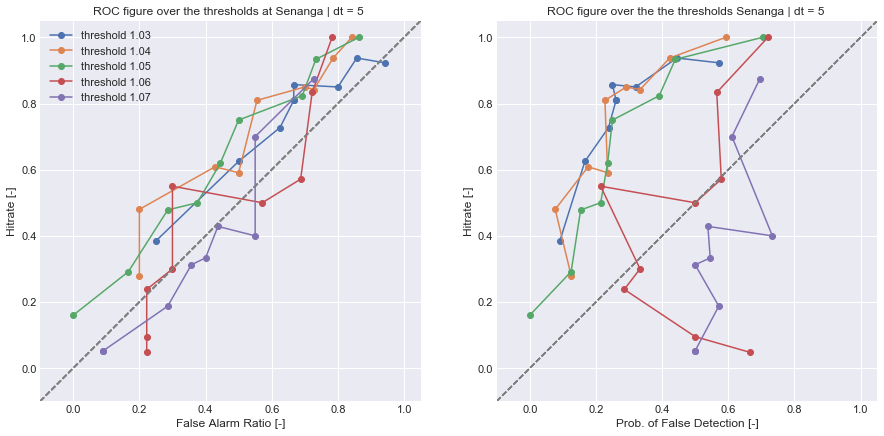

In [7]:
plt.figure(figsize=(15,15))
sns.set()
sns.color_palette()
style.use('seaborn-darkgrid')
for n in range (5):

    plt.subplot(1,2,1)
    plt.plot(ROC[n,:,2],ROC[n,:,0],'-o',label=f'threshold {1.03+n*0.01}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over the thresholds at {location} | dt = {dt} ')
    plt.ylabel('Hitrate [-]')
    
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    plt.xlabel('False Alarm Ratio [-]')
    plt.legend(loc='best')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(ROC[n,:,1],ROC[n,:,0],'-o',label=f'threshold {1.03+n*0.01}')#,color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over the the thresholds {location} | dt = {dt} ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    

    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(loc='best')
    plt.draw()  

# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Final/ROCthreshold_dt{dt}_{location}_{SAT}.png'),dpi=400)


In [23]:
# Run the ROC figures over all the dt positions
ROC =np.zeros((10,9,4))
threshold =1.062
#1.062 # 2 rp van discharge
#1.0888 # 5 rp van discharge
#1.0931321351216208 # 10 rp van discharge

# 1.074848 #yam 2 yr RP
# 1.090    #yam 5 yr RP
# 1.1085 #yam 10 yr RP


shift= 14
plot=0
rollingvalue=6


df = loadCMSAV(points_xy,ds,windowlength, polyorder)
df = applyshift(df,rollingvalue,shift,plot,SAT)

# df

for i, n in enumerate(range(7, 14, 1)):
    dt = n
    print(f'Calculating time window: {n} (days)')
    fits,res = calculateQR(df,selection,plot,shift,location)

    pred = probability(df, fits, plot, shift,location)
    obs = df.POI4.values.copy()
    
    for percentile in range(9):
        
        pred = probability(df, fits, plot, shift,location)
        obs = df.POI4.values.copy()
        
        performance, output, metric = calc_performance_scores_new(df, obs, pred, threshold , dt, percentile)
        
        ROC [i, percentile]= output
#         print(metric)


# result = pd.DataFrame(data=ROC[0,:,:],index=['10%','20%','30%','40%','50%','60%','70%','80%','90%'],columns=['POD','FAR','POFD','CSI']) #
# result['Classification'] = np.where(((result.FAR>0) & (result.POD>0.70)),'YES','NO')


Calculating time window: 7 (days)
Calculating time window: 8 (days)
Calculating time window: 9 (days)
Calculating time window: 10 (days)
Calculating time window: 11 (days)
Calculating time window: 12 (days)
Calculating time window: 13 (days)


In [24]:
# dt=2 # for 7 day forecast
dt=5 # for the 4 day forecast

result = pd.DataFrame(data=ROC[dt,:,:],index=['Q 10%','Q 20%','Q 30%','Q 40%','Q 50%','Q 60%','Q 70%','Q 80%','Q 90%'],columns=['POD','FAR','POFD','CSI']) #
result['Classification'] = np.where(((result.FAR<=0.3) & (result.POD>=0.70)),'YES','NO')
result

,POD,FAR,POFD,CSI,Classification
Q 10%,0.250000,0.000000,0.000000,0.250000,NO
Q 20%,0.421053,0.200000,0.181818,0.380952,NO
Q 30%,0.631579,0.142857,0.181818,0.571429,NO
Q 40%,0.666667,0.200000,0.250000,0.571429,NO
Q 50%,0.666667,0.200000,0.250000,0.571429,NO
Q 60%,0.833333,0.166667,0.250000,0.714286,YES
Q 70%,0.888889,0.238095,0.416667,0.695652,YES
Q 80%,0.944444,0.260870,0.500000,0.708333,YES
Q 90%,1.000000,0.440000,0.687500,0.560000,NO


In [26]:
ROC

array([[[0.05      , 0.        , 0.        , 0.05      ],
        [0.15789474, 0.4       , 0.18181818, 0.14285714],
        [0.31578947, 0.25      , 0.18181818, 0.28571429],
        [0.55555556, 0.23076923, 0.25      , 0.47619048],
        [0.61111111, 0.21428571, 0.25      , 0.52380952],
        [0.76470588, 0.23529412, 0.30769231, 0.61904762],
        [0.8       , 0.4       , 0.53333333, 0.52173913],
        [0.75      , 0.57142857, 0.66666667, 0.375     ],
        [0.88888889, 0.66666667, 0.76190476, 0.32      ]],

       [[0.05      , 0.        , 0.        , 0.05      ],
        [0.21052632, 0.33333333, 0.18181818, 0.19047619],
        [0.47368421, 0.18181818, 0.18181818, 0.42857143],
        [0.61111111, 0.21428571, 0.25      , 0.52380952],
        [0.66666667, 0.2       , 0.25      , 0.57142857],
        [0.76470588, 0.23529412, 0.30769231, 0.61904762],
        [0.8125    , 0.35      , 0.5       , 0.56521739],
        [0.78571429, 0.47619048, 0.625     , 0.45833333],
        [0.9

<ipython-input-25-15f2330f5d63>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-25-15f2330f5d63>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


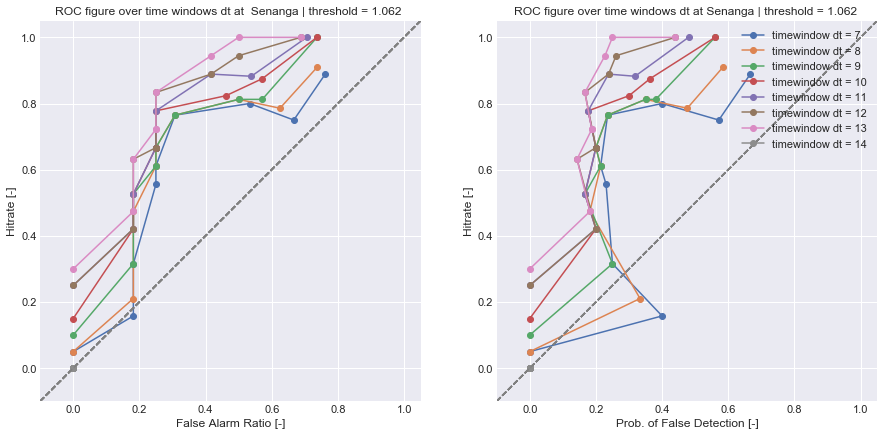

In [25]:
plt.figure(figsize=(15,15))

for n in range (8):

    plt.subplot(1,2,1)
    plt.plot(ROC[n,:,2],ROC[n,:,0],'-o',label= f'timewindow dt ={n+7}'),'-' #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over time windows dt at  {location} | threshold = {threshold} ')
    plt.ylabel('Hitrate [-]')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    plt.xlabel('False Alarm Ratio [-]')
#     plt.legend(loc='best')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(ROC[n,:,1],ROC[n,:,0],'-o',label=f'timewindow dt = {n+7}'),'-'#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over time windows dt at {location} | threshold = {threshold} ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(loc='upper right')
    plt.draw()  

# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Final/ROC_overdtwiththreshold{threshold}_{location}_{SAT}.png'),dpi=400)


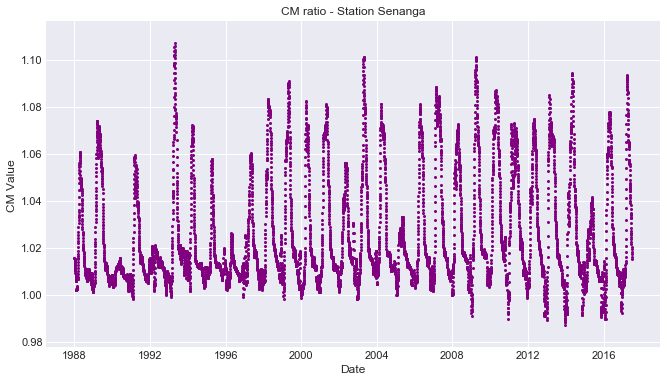

In [8]:
plot=0
df = loadCMSAV(points_xy,ds,windowlength, polyorder)
df = applyshift(df,rollingvalue,shift,plot,SAT)
# Plot using matplotlib
fig, ax = plt.subplots(figsize=(11, 6))

ax.scatter(x=df.index,
           y=df["POI4"],
           marker="o",
           s=4,
           color="purple")

ax.set(xlabel="Date", ylabel="CM Value ",
       title="CM ratio - Station Senanga")

plt.show()



In [9]:
df_year = df
df_year["year"] = df.index.year
df_year_annualmax = df_year.resample('AS').max()
df_year_annualmax


df_season_all = df_year[df_year.index.month >1] 
df_season_all = df_year[df_year.index.month <6] 
# df_season_all = df_year.loc[(df_year.index.month 11)]
df_season_all


,POI1,POI4,year
1988-01-01,NaN,1.015655,1988
1988-01-02,NaN,1.015456,1988
1988-01-03,NaN,1.015257,1988
1988-01-04,NaN,1.015057,1988
1988-01-05,NaN,1.014858,1988
...,...,...,...
2017-05-27,1.061664,1.045590,2017
2017-05-28,1.061126,1.045319,2017
2017-05-29,1.058841,1.045048,2017
2017-05-30,1.058263,1.044342,2017


In [10]:
def calculate_return(df, colname):

    # Sort data smallest to largest
    sorted_data = df.sort_values(by=colname)
    
    # Count total obervations
    n = sorted_data.shape[0]
    
    # Add a numbered column 1 -> n to use in return calculation for rank
    sorted_data.insert(0, 'rank', range(1, 1 + n))
    
    # Calculate probability
    sorted_data["probability"] = (n - sorted_data["rank"] + 1) / (n + 1)
    
    # Calculate return - data are daily to then divide by 365?
    sorted_data["return_years"] = (1 / sorted_data["probability"])

    return(sorted_data)

In [11]:
dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';')#, header=0, parse_dates=[0], index_col=0, squeeze=False, na_filter=True)#, parse_dates=['DATE'],index_col = ['DATE'])

dQ['Datetime'] = pd.to_datetime(dQ['Date'], format='%d-%m-%Y')
dQ = dQ.set_index('Datetime')
dQ= dQ[dQ.index.year>1987]
dQ= dQ[dQ.index.year<2017]
dQ=dQ.sort_index()
dQ =dQ.drop('Date', 1) 

                       
df_total= pd.concat([dQ , df['POI4']], join="outer",  axis=1, ignore_index=False)
df_total=df_total.dropna()

df_total.columns=['Q_Kalobo','Q_Senanga','POI_downstream']
dQ_year = df_total
dQ_year["year"] = df_total.index.year
dQ_year_annualmax = dQ_year.resample('AS').max()
dQ_year_annualmax


x = df_total['Q_Senanga'].values

y = df_total['POI_downstream'].values
deg =2

z = np.polyfit(x,y,2)
p_cm = np.poly1d(z)



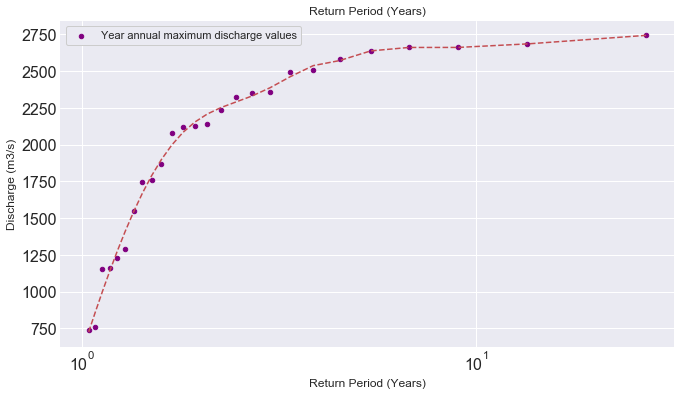

,rank,Q_Kalobo,Q_Senanga,POI_downstream,year,probability,return_years
2013-01-01,1,163.0,738.0,0.994586,2013,0.962963,1.038462
1993-01-01,2,16.0,761.0,1.007835,1993,0.925926,1.080000
1996-01-01,3,31.0,1155.0,1.026325,1996,0.888889,1.125000
1992-01-01,4,52.0,1164.0,1.021099,1992,0.851852,1.173913
1990-01-01,5,118.0,1232.0,1.015620,1990,0.814815,1.227273
1988-01-01,6,96.0,1290.0,1.025999,1988,0.777778,1.285714
2005-01-01,7,79.0,1550.0,1.033132,2005,0.740741,1.350000
1997-01-01,8,132.0,1748.0,1.060208,1997,0.703704,1.421053
1995-01-01,9,22.0,1758.0,1.057900,1995,0.666667,1.500000
2002-01-01,10,141.0,1865.0,1.055334,2002,0.629630,1.588235


In [12]:
colname ='Q_Senanga'
dQ_sorted = calculate_return(dQ_year_annualmax,colname)



fig, ax = plt.subplots(figsize=(11, 6))

dQ_sorted.plot.scatter(y=colname,
                           x='return_years',
                           title="Return Period (Years)",
                           ax=ax,
                           color='purple',
                           fontsize=16,
                           label="Year annual maximum discharge values")

ax.legend(frameon=True,
          framealpha=1)
ax.set_xscale('log')
ax.set_xlabel("Return Period (Years)")
ax.set_ylabel("Discharge (m3/s)")
z=np.polyfit(dQ_sorted.return_years,dQ_sorted.Q_Senanga , deg=10)
dQ_sortedp = np.poly1d(z)
plt.plot(dQ_sorted.return_years,dQ_sortedp(dQ_sorted.return_years),"r--"  )


plt.show()

# dQ_sorted = dQ_sorted[dQ_sorted.return_years>1.9999]
dQ_sorted.head(60)
# dQ_sortedp(13)

In [164]:
#enter discharge you want to calculate for

Q = input("Enter the discharge you want to calculate the CM ratio for for: ")

rp = p_cm(int(Q))
print('The CM value is...')
print(rp)


Enter the discharge you want to calculate the CM ratio for for: 2344
The CM value is...
1.074710624340594


Enter: what to choose, year annual max or full wet season: yam, fws: yam


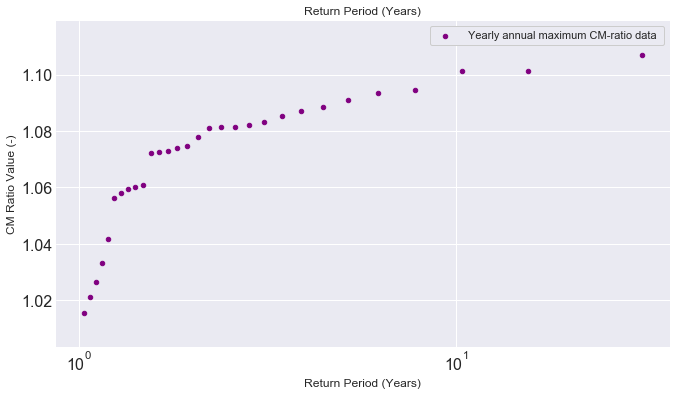

,rank,POI1,POI4,year,probability,return_years
1990-01-01,1,1.021310,1.015620,1990,0.967742,1.033333
1992-01-01,2,1.022133,1.021099,1992,0.935484,1.068966
1996-01-01,3,1.030884,1.026325,1996,0.903226,1.107143
2005-01-01,4,1.044309,1.033132,2005,0.870968,1.148148
2015-01-01,5,1.052362,1.041677,2015,0.838710,1.192308
2002-01-01,6,1.065507,1.056109,2002,0.806452,1.240000
1995-01-01,7,1.067350,1.057900,1995,0.774194,1.291667
1991-01-01,8,1.087643,1.059276,1991,0.741935,1.347826
1997-01-01,9,1.066462,1.060208,1997,0.709677,1.409091
1988-01-01,10,1.060423,1.060791,1988,0.677419,1.476190


In [119]:
colname = 'POI4' #POI to calculate return period on

Q2 = input("Enter: what to choose, year annual max or full wet season: yam, fws: ")
if Q2 == 'yam':
    dfinput = df_year_annualmax
elif Q2 == 'fws':
    dfinput = df_season_all

#df_season_all
df_sorted = calculate_return(dfinput, colname)
# z=np.polyfit(df_sorted.POI4 ,df_sorted.return_years, deg=10)
# df_sortedp = np.poly1d(z)


fig, ax = plt.subplots(figsize=(11, 6))
# ax.plot(df_sorted.return_years,df_sortedp(df_sorted.return_years),"r--"  )

df_sorted.plot.scatter(y=colname,
                           x='return_years',
                           title="Return Period (Years)",
                           ax=ax,
                           color='purple',
                           fontsize=16,
                           label=" Yearly annual maximum CM-ratio data ")

ax.legend(frameon=True,
          framealpha=1)
ax.set_xscale('log') 
ax.set_xlabel("Return Period (Years)")
ax.set_ylabel("CM Ratio Value (-)")


plt.show()
# # df_sorted = df_sorted[df_sorted.return_years>1.9999]
# # df_sorted = df_sorted[df_sorted.return_years<10.3] 

df_sorted = df_sorted[df_sorted.return_years>1]
df_sorted


In [26]:
# 1.074848 #yam 2 yr RP
# 1.090    #yam 5 yr RP
# 1.1085 #yam 10 yr RP

# #enter discharge you want to calculate for

# cm = input("Enter the returnperiod you want to calculate the CM ratio for for: ")

# rp = df_sortedp(int(cm))
# print('The CM value is...')
# print(rp)


In [27]:
# #%% CALCULATE RETURN PERIOD FOR KNOWN FLOOD EVENT USING ANNUAL MAXIMA (ONLY REALLY WORKS WITH LONG TERM DATA THO)

# dQ_year = pd.read_csv('/Users/lonem/OneDrive/Documenten/Lund University/THESIS/DATA/FinalLocationsFormatted/ShiredQ_yearwawa.csv', delimiter = ';', header = 0, na_filter=True)
# dQ_year.columns = ['doy','Discharge']
# dQ_year['doy'] = pd.to_datetime(dQ_year['doy'], dayfirst=True)
# #Set dates as index for resampling
# dQ_year.index = dQ_year['doy']
# #Drop date column
# dQ_year = dQ_year.drop(['doy'], axis=1)

# #Add year column (comes in handy for plotting)
# dQ_year["year"] = dQ_year.index.year

dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';')#, header=0, parse_dates=[0], index_col=0, squeeze=False, na_filter=True)#, parse_dates=['DATE'],index_col = ['DATE'])

dQ['Datetime'] = pd.to_datetime(dQ['Date'], format='%d-%m-%Y')
dQ = dQ.set_index('Datetime')
dQ= dQ[dQ.index.year>1987]
dQ= dQ[dQ.index.year<2017]
dQ=dQ.sort_index()
dQ =dQ.drop('Date', 1) 
df_total= pd.concat([dQ , df['POI4']], join="outer",  axis=1, ignore_index=False)
df_total=df_total.dropna()

df_total.columns=['Q_Kalobo','Q_Senanga','POI_downstream']
dQ_year = df_total
dQ_year["year"] = df_total.index.year



#Add flood season column (to avoid non-detection of nov-dec floods if peaks occurred earlier in the year)
#e.g. The 2014 flood season covers May 2014 until April 2015
dQ_year["floodseason"] = dQ_year["year"]
dQ_year.loc[dQ_year.index.month < 5, "floodseason"] = dQ_year["floodseason"]-1  #will make the year run from May to April instead of January to December
dQ_year["floodseason"] = pd.to_datetime(dQ_year["floodseason"], format='%Y')

# CALCULATING MAXIMA:
#CHOOSE STRATEGY (yearly or seasonally)
mode = input('Choose strategy. Type yearly, seasonally or onlyseason, look at documentation above: ')
             
if mode == 'yearly':
    dQ_year["date"] = dQ_year.index
    #CALCULATE ANNUAL MAXIMUM
    dQ_yearannual = dQ_year.resample('AS').max()
elif mode == 'seasonally':
    #add date column to preserve original moment of flooding
    dQ_year["date"] = dQ_year.index
    #resample based on flood season rather than year
    dQ_yearannual = dQ_year.resample('AS', on='floodseason').max()
elif mode == 'onlyseason':
    dQ_year["flood"] = 0
    dQ_year.loc[(dQ_year.index.month <6), "flood"] = 1
    dQ_year.loc[(dQ_year.index.month >11), "flood"] = 1
    wetdays = dQ_year["flood"] == 1
    dQ_year = dQ_year[wetdays]
    maxornot = input('Do you want to look at maxima, quantiles, or all data values in wet season? Type max, quant or val: ')
    if maxornot == 'max':
        dQ_yearannual = dQ_year.resample('AS', on='floodseason').max()
    elif maxornot == 'val':
        dQ_yearannual = dQ_year
    elif maxornot == 'quant':
        quant = input('What quantile do you want to use? (value between 0 and 1): ')
        wetterdays = dQ_year["Q_Senanga"] > dQ_year["Q_Senanga"].quantile(float(quant))
        dQ_yearannual = dQ_year[wetterdays]
    else:
        print('error')
        exit()
else: 
    print('error')
    exit()
    
#Drop na, sort ascending
dQ_yearannual = dQ_yearannual.dropna()
dQ_yearannual_sorted = dQ_yearannual.sort_values(by="Q_Senanga")
# count total observations
n = dQ_yearannual_sorted.shape[0]
# Add a numbered column 1 -> n to use in return calculation for rank
dQ_yearannual_sorted.insert(0, 'rank', range(1, 1 + n))

# Calculate probability - note you may need to adjust this value based upon the time period of your data
dQ_yearannual_sorted["probability"] = ((n - dQ_yearannual_sorted["rank"] + 1) / (n + 1))
dQ_yearannual_sorted["return-years"] = (1 / dQ_yearannual_sorted["probability"])

#%% CALCULATE RETURN PERIOD FOR GIVEN PEAK DISCHARGE(if you want to calculate the return period of a certain flood)

#Create relationship return period vs. discharge
x = dQ_yearannual_sorted['Q_Senanga']
y = dQ_yearannual_sorted['return-years']
plt.scatter(x,y)
z = np.polyfit(x, y, 3) #3rd degree
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()


#enter discharge you want to calculate for
Q = input("Enter the discharge you want to calculate the return period for: ")
rp = p(int(Q))
print('The return period is...')
print(rp)

KeyboardInterrupt: 

## Function to compute confusion matrix (hits, false alarms, misses, correct negatives) and performance indexes (FAR, POD, POFD, CSI))



Methodology adapted taking into account the consecutive day above thresholds as a unique flood period

hits:              Number of peak period above thresholds that have at least one observation day within the period

false alarm :      number of peak above threshold(consecutive day above discharge threshold as an event), minus the number of hits

misses :           number of observed flood events no in a discharge peak period  above threshold

correct negative : forcing the correct negative number to be the same than the number of observed flood events (misses + hits)



In [82]:
def calc_performance_scores(obs, pred):
    df= pd.DataFrame({'cons_class': pred.diff().ne(0).cumsum(), 'hits':(obs==1) & (pred ==1)})
    hits= df[['cons_class','hits' ]].drop_duplicates().hits[df.hits == True].count()
    false_al = (pred.loc[pred.shift() != pred].sum()) - hits 
    misses = sum((obs == 1) & (pred ==0))
    corr_neg = misses + hits
    
    output = {}
    output['pod'] = hits / (hits + misses)
    output['far'] = false_al / (hits + false_al)
    output['pofd'] = false_al / (false_al + corr_neg)
    output['csi'] = hits / (hits + false_al + misses)
    
    output = pd.Series(output)
    return output


In [126]:
pred = probability(df, fits, plot, shift,location)

len(pred[1])

10774

In [65]:
def calc_performance_scores(obs, pred, threshold):
    obs_func =np.zeros(len(obs))
    pred_func =np.zeros(len(obs))
 
    for i in range(len(obs)):
        if obs[i] > threshold:
            obs_func[i] =1
        else:
            obs_func[i]=0
            
    for j in range(len(pred)):
        if pred[j] > threshold:
            pred_func[j] =1
        else:
            pred_func[j]=0

#     print(obs)
#     print(pred) 

    
    
    hits = len(np.where((obs_func==1) & (pred_func ==1))[0])
    false_al = len(np.where((obs_func==0) & (pred_func ==1))[0])
    misses = len(np.where((obs_func==1) & (pred_func ==0))[0])
    corr_neg = len(np.where((obs_func==0) & (pred_func==0))[0])
    
#     print((hits))
#     print((misses))
#     print((false_al))
#     print((corr_neg))

    try:
        output = np.zeros((4,))
        
        if hits+misses ==0:
            output[0]=np.nan
        else:
            output[0] = np.sum(hits) / (np.sum(hits) + np.sum(misses)) #Probability of Detection or  HR
       
        if hits+false_al ==0:
            output[1]=np.nan
        else:
            output[1] = np.sum(false_al) / (np.sum(hits) + np.sum(false_al)) #False Alarm Ratio
        
        if false_al+corr_neg ==0:
            output[2]=np.nan
        else:
            output[2] = np.sum(false_al) / (np.sum(false_al) + np.sum(corr_neg)) #Probability of fase detectiono or false alarm rate

        if hits+false_al+misses ==0:
            output[3]=np.nan
        else:
            output[3] = np.sum(hits) / (np.sum(hits) + np.sum(false_al) + np.sum(misses)) #Critical succes index
        

    except ZeroDivisionError:
        return -99
   


    return output 


#     df= pd.DataFrame({'cons_class': pred.diff().ne(0).cumsum(), 'hits':(obs==1) & (pred ==1)})
#     hits= df[['cons_class','hits' ]].drop_duplicates().hits[df.hits == True].count()
#     false_al = (pred.loc[pred.shift() != pred].sum ()) - hits 
#     misses = sum((obs == 1) & (pred ==0))
#     corr_neg = misses + hits


#     output = {}
#     output['pod'] = hits / (hits + misses) #Probability of Detection
#     output['far'] = false_al / (hits + false_al) #False Alarm Rate
#     output['pofd'] = false_al / (false_al + corr_neg) #Probability of fase detection
#     output['csi'] = hits / (hits + false_al + misses) #Critical succes index
#output=pd.Series(output)


Calculating threshold: 1.03 (cm ratio)
Calculating threshold: 1.04 (cm ratio)
Calculating threshold: 1.05 (cm ratio)
Calculating threshold: 1.06 (cm ratio)
Calculating threshold: 1.07 (cm ratio)
Calculating threshold: 1.08 (cm ratio)
Calculating threshold: 1.09 (cm ratio)
Calculating threshold: 1.1 (cm ratio)


<ipython-input-127-d2b1ada09b66>:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-127-d2b1ada09b66>:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


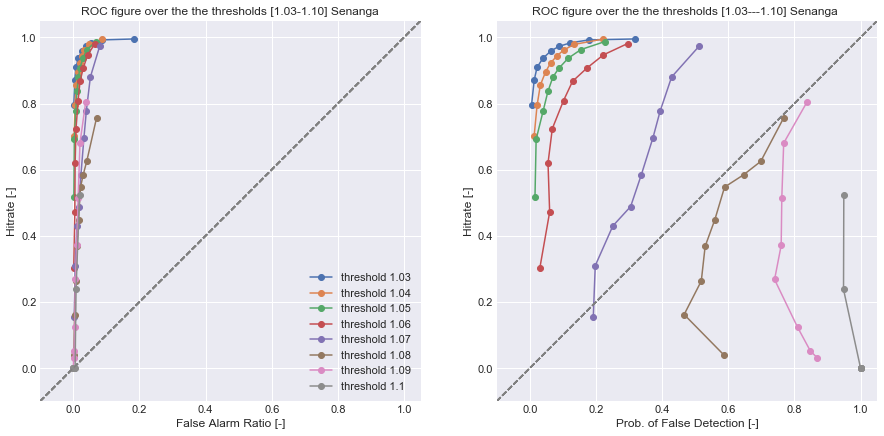

In [127]:
ROC =np.zeros((8,9,4))

plot=0


for i, n in enumerate([1.03, 1.04, 1.05, 1.06, 1.07, 1.08 ,1.09 ,1.10]):#)]):#,
    threshold = n
    
    print(f'Calculating threshold: {n} (cm ratio)')
    fits,res = calculateQR(df,selection,plot,shift,location)

    pred = probability(df, fits, plot, shift,location)
    obs = df.POI4.values.copy()
    
    for percentile in range(9):
        
        pred = probability(df, fits, plot, shift,location)
        obs = df.POI4.values.copy()
        pred=pred[percentile]
#         print(pred)
        output= calc_performance_scores(obs,pred , threshold)
        
        ROC [i, percentile]= output


plt.figure(figsize=(15,15))
sns.set()
sns.color_palette()
style.use('seaborn-darkgrid')
for n in range (8):

    plt.subplot(1,2,1)
    plt.plot(ROC[n,:,2],ROC[n,:,0],'-o',label=f'threshold {1.03+n*0.01}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over the the thresholds [1.03-1.10] {location}')
    plt.ylabel('Hitrate [-]')
    
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    plt.xlabel('False Alarm Ratio [-]')
    plt.legend(loc='best')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(ROC[n,:,1],ROC[n,:,0],'-o',label=f'threshold {1.03+n*0.01}')#,color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over the the thresholds [1.03---1.10] {location} ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    

    plt.gca().set_aspect('equal', adjustable='box')
#     plt.legend(loc='best')
    plt.draw()  
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/ROCthreshold_dt{dt}_{location}_{SAT}.png'),dpi=400)


In [108]:
dt=3
# for 7 day forecast
# for the 4 day .forecast

result = pd.DataFrame(data=ROC[dt,:,:],index=['Q 10%','Q 20%','Q 30%','Q 40%','Q 50%','Q 60%','Q 70%','Q 80%','Q 90%'],columns=['POD','FAR','POFD','CSI']) #
result['Classification'] = np.where(((result.FAR<=0.3) & (result.POD>=0.70)),'YES','NO')
result

,POD,FAR,POFD,CSI,Classification
Q 10%,0.301342,0.030238,0.001508,0.298537,NO
Q 20%,0.471812,0.060160,0.004847,0.457980,NO
Q 30%,0.620134,0.055215,0.005816,0.598446,NO
Q 40%,0.724161,0.068221,0.008509,0.687699,YES
Q 50%,0.808725,0.102086,0.014757,0.740627,YES
Q 60%,0.867114,0.129380,0.020681,0.768133,YES
Q 70%,0.907383,0.173089,0.030483,0.762549,YES
Q 80%,0.946980,0.222590,0.043516,0.744984,YES
Q 90%,0.981208,0.295761,0.066135,0.694867,YES


In [132]:
plot=0

df = loadCMSAV(points_xy, ds, windowlength, polyorder)
df = applyshift(df,rollingvalue,shift,plot,SAT)
fits,res = calculateQR(df,selection,plot,shift,location)
pred = probability(df, fits, plot, shift,location)

obs = df.POI4.values.copy()
# threshold =1

array([1.0156554, 1.015456 , 1.0152566, ..., 1.0172015, 1.0161327,
       1.0150639], dtype=float32)

array([[[0.7946632 , 0.00529532, 0.00168809, 0.79131562],
        [0.87146111, 0.01362799, 0.00480457, 0.86109325],
        [0.90920924, 0.0220511 , 0.00818076, 0.89094388],
        [0.93621868, 0.039399  , 0.01532269, 0.90159825],
        [0.95964855, 0.06470029, 0.02649007, 0.89990845],
        [0.97299056, 0.08924764, 0.03804701, 0.88829471],
        [0.98340384, 0.12304121, 0.05505778, 0.86416929],
        [0.99219004, 0.17816712, 0.08583301, 0.81655062],
        [0.99511878, 0.31801963, 0.18517076, 0.6797066 ]],

       [[0.70160974, 0.01325235, 0.00291722, 0.69506029],
        [0.795053  , 0.02221149, 0.00559135, 0.78094871],
        [0.85551629, 0.03198578, 0.00875167, 0.83199695],
        [0.89595603, 0.04797664, 0.01397836, 0.85725019],
        [0.92304672, 0.06334661, 0.01932661, 0.86881005],
        [0.94424814, 0.08241129, 0.02625501, 0.87043069],
        [0.96152336, 0.10260169, 0.03403428, 0.86628935],
        [0.97840597, 0.13351878, 0.04667558, 0.85022177],
        [0.9

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True) #remove any NaN values
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True) #remove any NaN values
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-ma

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True) #remove any NaN values
<ipython-input-1111-ed340faf8e70>:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


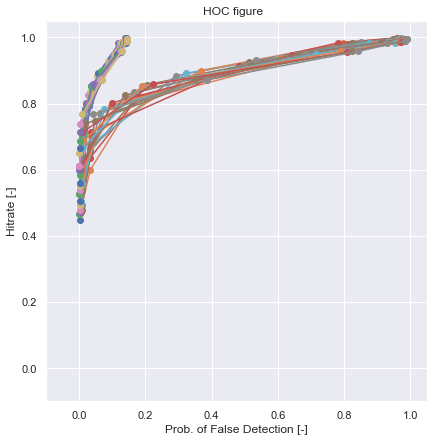

In [1111]:
# Run the ROC figures over all the shift positions
ROC =np.zeros((20,5,4))
threshold =1.0

for i, n in enumerate(range(0, 20, 1)):
    shift = n
    df = loadCM(points_xy,ds, rollingvalue)
    df = applyshift(df,rollingvalue,shift,plot)
    fits,res = calculateQR(df,selection,plot,shift,location)
    pred = probability(df, fits, plot, shift,location)
    obs = df.POI4.values.copy()
    

    for j in range (5):
        output = calc_performance_scores(obs,pred[j],threshold)
        pred = probability(df, fits, plot, shift,location)
        obs = df.POI4.values.copy()
        ROC [i, j]= output
# ROC

plt.figure(figsize=(15,15))
for n in range (20):

    plt.plot(ROC[n,:,2],ROC[n,:,0],'-o') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

    plt.subplot(1,2,2)
    plt.plot(ROC[n,:,1],ROC[n,:,0],'-o')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure  ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

<ipython-input-413-22ce8b41fe54>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-413-22ce8b41fe54>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


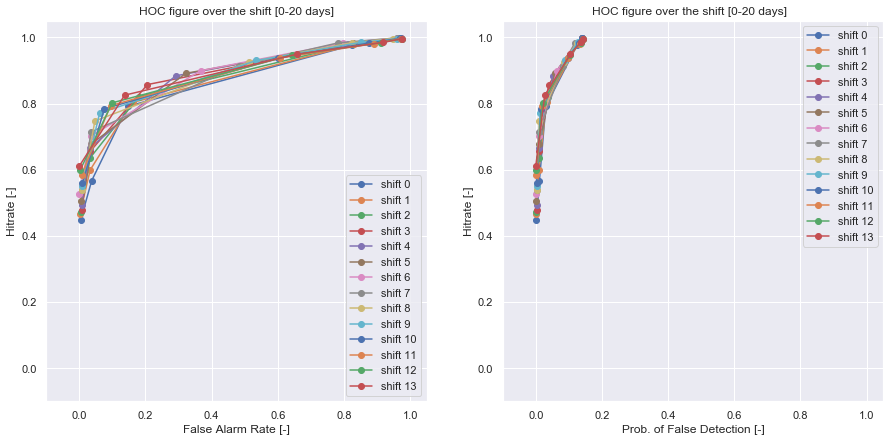

In [413]:
plt.figure(figsize=(15,15))
for n in range (14):

    plt.subplot(1,2,1)
    plt.plot(ROC[n,:,2],ROC[n,:,0],'-o',label=f'shift {n}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over the shift [0-20 days] {location}')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()

    plt.subplot(1,2,2)
    plt.plot(ROC[n,:,1],ROC[n,:,0],'-o',label=f'shift {n}')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over the shift [0-20 days] {location} ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
        
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/ROC_Shift{location}.png'),dpi=400)


In [417]:
# Run the ROC figures over the threshold bounds
ROC =np.zeros((5,5,4))
shift =7
for i, n in enumerate([ 0.98, 0.99, 1, 1.01,1.02,1.03,1.04,1.05, 1.06,1.07, 1.08, 1.09 ,1.10, 1.11,1.12,1.13,1.14]):
    threshold = n
    df = loadCM(points_xy,ds, rollingvalue)
    df = applyshift(df,rollingvalue,shift,plot)
    fits,res = calculateQR(df,selection,plot,shift,location)
    pred = probability(df, fits, plot, shift,location)
    obs = df.POI4.values.copy()
    
    
    for j in range (5):
        output = calc_performance_scores(obs,pred[j],threshold)
        pred = probability(df, fits, plot, shift,location)
        obs = df.POI4.values.copy()
        ROC [i, j]= output
#         output =calc_performance_scores(obs,pred[j],threshold)
# ROC


plt.figure(figsize=(15,15))

for n in range (17):

    plt.subplot(1,2,1)
    plt.plot(ROC[n,:,2],ROC[n,:,0],'-o') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over the the thresholds [1.01-1.14]')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('False Alarm Rate [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(ROC[n,:,1],ROC[n,:,0],'-o')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over the the thresholds [1.01-1.14] ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()  

/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[n][df[n]<0] = df[n].fillna(method='bfill',inplace=True)
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:57: Setting

IndexError: index 5 is out of bounds for axis 0 with size 5

In [521]:
plot=0

In [522]:
df = loadCMSAV(points_xy, ds, windowlength, polyorder)
# df = applyshift(df,rollingvalue,shift,plot,SAT)

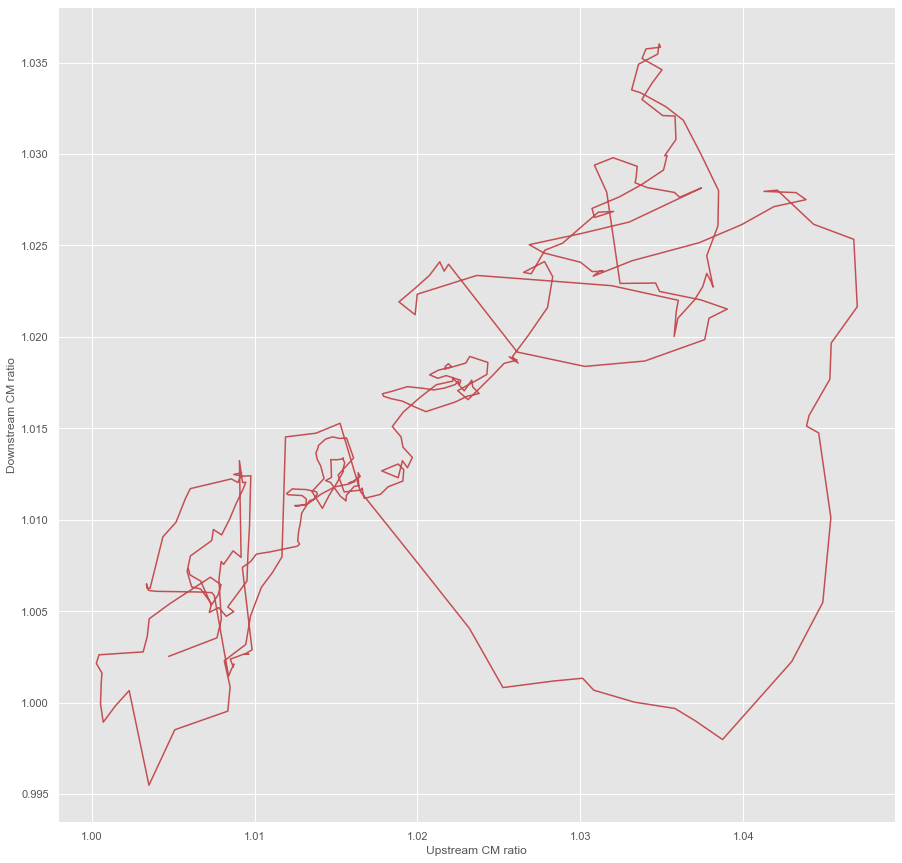

In [556]:
df_sel =df[df.index.year==2005]
plt.figure(figsize=(15,15))
plt.xlabel('Upstream CM ratio')
plt.ylabel('Downstream CM ratio')
plt.plot(df_sel.POI1,df_sel.POI4,'r')

In [555]:


def calc_performance_scores_try(df, obs, pred, threshold , dt, percentile):
#     np.seterr(divide='ignore', invalid='ignore')

    df = np.where((df.index.month == 2) & (df.index.day == 1))[0] # select only the moment in time the rainseason starts to find the first moment above the trheshold
    performance = np.zeros((len(df),4)) # create performance matrix 1 = date obs_threshold 2 obs_threshold 3. date pred_thres 4 pred_thres
   
    for t in range (30): # 30 for DSMP data set, 8 for AMSR-E, (4,5 for a year)
        obs_threshold = np.where((obs[df[t]: df[t]+365]) > threshold)[0] 


        if len(obs_threshold) > 0:   #alles wat groter dan nul is -> hit of een miss
                obs_threshold0 = obs_threshold[0] + df[t]
                pred_threshold = np.where(pred[percentile][obs_threshold0-dt:obs_threshold0+dt] > threshold)[0] + (obs_threshold0-dt)
                
                if len(pred_threshold) > 0: #hit
                    performance [t][0] = obs_threshold0 
                    performance [t][1] = 1
                    performance [t][2] = min(pred_threshold)       
                    performance [t][3] = 1      
#                     print('Hit')
                else:       # miss!            
                    performance [t][0] = obs_threshold0 
                    performance [t][1] = 1           
                    performance [t][2] = len(pred_threshold)
                    performance [t][3] = 0
#                     print('Miss')    
                    
           
        
        pred_threshold2 = np.where((pred[percentile][df[t]: df[t]+365]) > threshold)[0]

        if len(pred_threshold2)> 0: #alles wat groter dan nul is ->  FA of HIT
                
                pred_threshold3 = pred_threshold2[0]  + df[t]
                obs_threshold2 = np.where(obs[pred_threshold3-dt:pred_threshold3+dt] > threshold)[0] + (pred_threshold3-dt)
               
                if len(obs_threshold2) == 0: #alles wat groter dan nul is -> FA of CN
                    
                    performance [t][0] = len(obs_threshold2) 
                    performance [t][1] = 0
                    performance [t][2] = pred_threshold3
                    performance [t][3] = 1    
#                     print('False Alarm')   
       
        if len(obs_threshold) == 0: # CN
             if len(pred_threshold2) == 0:
                    
                    performance [t][0] = -999
                    performance [t][1] = 0           
                    performance [t][2] = -999
                    performance [t][3] = 0     
#                     print('Correct Negative')

    performance =pd.DataFrame(performance)
    
    performance.columns = ['day obs', 'obs', 'day pred', 'pred']    
    hits = len(np.where((performance.obs==1) & (performance.pred ==1))[0])    
    false_al = len(np.where((performance.obs==0) & (performance.pred ==1))[0])
    misses = len(np.where((performance.obs==1) & (performance.pred ==0))[0])
    corr_neg = len(np.where((performance.obs==0) & (performance.pred ==0))[0])



    try:
        output = np.zeros((4,))
        
        if hits+misses ==0:
            output[0]=np.nan
        else:
            output[0] = np.sum(hits) / (np.sum(hits) + np.sum(misses)) #Probability of Detection or  HR
       
        if hits+false_al ==0:
            output[1]=np.nan
        else:
            output[1] = np.sum(false_al) / (np.sum(hits) + np.sum(false_al)) #False Alarm Ratio
        
        if false_al+corr_neg ==0:
            output[2]=np.nan
        else:
            output[2] = np.sum(false_al) / (np.sum(false_al) + np.sum(corr_neg)) #Probability of fase detectiono or false alarm rate

        if hits+false_al+misses ==0:
            output[3]=np.nan
        else:
            output[3] = np.sum(hits) / (np.sum(hits) + np.sum(false_al) + np.sum(misses)) #Critical succes index
        

    except ZeroDivisionError:
        return -99
   

    metric = np.zeros((4,))
    metric[0] = hits
    metric[1] = false_al
    metric[2] = misses
    metric[3] = corr_neg

    
    return (performance,output,metric)
      
    

In [554]:
df = loadCMSAV(points_xy,ds,windowlength, polyorder)
df = applyshift(df,rollingvalue,shift,plot,SAT)

percentile:0
percentile:1
percentile:2
percentile:3
percentile:4
percentile:5
percentile:6
percentile:7
percentile:8
ROC(POD,FAR,POFD,CSI) for is: [[0.05       0.         0.         0.05      ]
 [0.26315789 0.16666667 0.09090909 0.25      ]
 [0.31578947 0.25       0.18181818 0.28571429]
 [0.52631579 0.16666667 0.18181818 0.47619048]
 [0.57894737 0.15384615 0.18181818 0.52380952]
 [0.625      0.33333333 0.35714286 0.47619048]
 [0.73333333 0.35294118 0.4        0.52380952]
 [0.81818182 0.55       0.57894737 0.40909091]
 [0.8        0.63636364 0.7        0.33333333]]


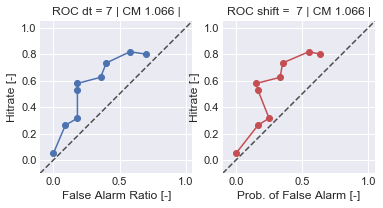

In [556]:

dt =7
shift=14
threshold=1.066
# percentile = 0

ROC =np.zeros((9,4))
plot=0

for percentile in range(9):
    print(f'percentile:{percentile}')
    performance, output, metric = calc_performance_scores_try(df, obs, pred, threshold , dt, percentile)

#     print(f'percentile from df {percentile}')
#     print(output)
#     print(performance)
#     print(f'{performance}')
#     print(f'output: {output}')
#     print(f'METRIC: HIT,FA,MISS,CN: print metric for percentile {percentile}: {metric}')
    ROC [percentile] = output


print(f'ROC(POD,FAR,POFD,CSI) for is: {ROC}')

    

plt.subplot(1,2,1)
plt.plot(ROC[:,2],ROC[:,0],'-o',color ='b')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'ROC dt = {dt} | CM {threshold} |')
plt.ylabel('Hitrate [-]')
plt.xlabel('False Alarm Ratio [-]')
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.draw()

plt.subplot(1,2,2)
plt.plot(ROC[:,1],ROC[:,0],'-o',color ='r')
plt.xlim([-0.1,1.05])
plt.ylim([-0.1,1.05])
plt.title(f'ROC shift =  {dt} | CM {threshold} |')
plt.ylabel('Hitrate [-]')
plt.xlabel('Prob. of False Alarm [-]')
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.draw()

# # plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/ROC_{shift}_{location}_{SAT}.png'),dpi=400)


